# Convolutional Neural Network With PyTorch

Based on https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy

In [1]:
# https://qiita.com/JUN_NETWORKS/items/c2f94f1775b6156b0105
# conda install pillow==6.2.1
# pillow の最新バージョン(7.0)だとエラーがでる（2020/01/09）
# conda install -c pytorch torchvision
# conda install pytorch torchvision cudatoolkit=x.x -c pytorch --> gpuがある場合

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

import time # 処理時間計測用

## Explore the Data

In [2]:
train_df = pd.read_csv('./data/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [3]:
test_df = pd.read_csv('./data/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


### Display some images

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu-PyTorch\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


3, 5, 1, 8, 0, 5, 8, 6


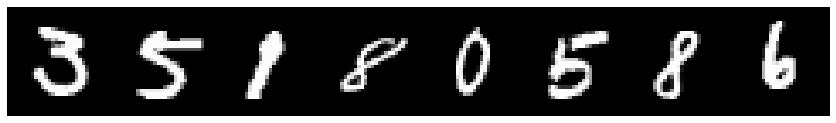

In [4]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].as_matrix()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

### Histogram of the classes

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


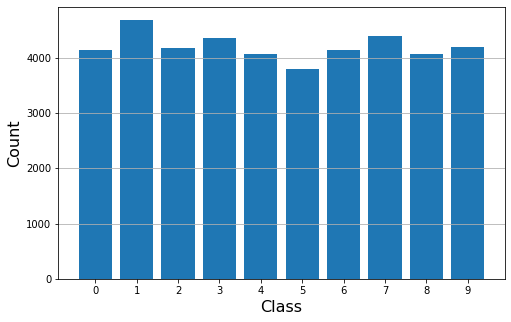

In [5]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

## Data Loader

In [6]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation Transformation

Keras には備わっている機能ですが、PyTorch では自分で関数を作らないといけません。

Randomly rotate the image. Available in upcoming torchvision but not now.

In [7]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

### Random Vertical and Horizontal Shift
こちらも自分で関数を作ります。

In [8]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Load the Data into Tensors
For the training set, apply random rotation within the range of (-45, 45) degrees, shift by (-3, 3) pixels
and normalize pixel values to [-1, 1].  For the test set, only apply nomalization.

In [9]:
batch_size = 64

train_dataset = MNIST_data('./data/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('./data/test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

### Visualize the Transformations

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


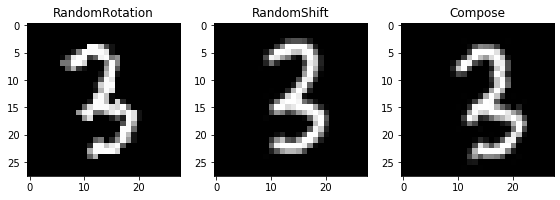

In [10]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(np.array(train_df.iloc[65,1:]).reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Network Structure

In [11]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [12]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu-PyTorch\lib\site-packages\ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [13]:
model

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p

## Training and Evaluation

In [14]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        start = time.time() # elapsed_time = time.time() - start
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        elapsed_time = time.time() - start # batch毎の処理時間
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\telapsed_time: {:.2f}sec'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item(), elapsed_time)) # 修正   

In [15]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    elapsed_time = time.time() - start # epoch毎の処理時間
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data.item() # 修正

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    correct = correct.to('cpu').detach().numpy() # pytorch tensor から numpy ndarray に変換
    accuracy = 100. * correct / len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Epoch time: {:.2f}sec\n'.format(
        loss, correct, len(data_loader.dataset), accuracy, elapsed_time))

### Train the network

Reaches 0.995 accuracy on test set after 50 epochs

In [16]:
n_epochs = 50

for epoch in range(n_epochs):
    start = time.time() # elapsed_time = time.time() - start
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.474269	elapsed_time: 0.02sec
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.290143	elapsed_time: 0.02sec
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.206994	elapsed_time: 0.02sec
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.226199	elapsed_time: 0.02sec
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.240445	elapsed_time: 0.02sec
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.294328	elapsed_time: 0.02sec


D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu-PyTorch\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu-PyTorch\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 0.1152, Accuracy: 40411/42000 (96.22%), Epoch time: 25.66sec

Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.092242	elapsed_time: 0.02sec
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.232714	elapsed_time: 0.02sec
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.198355	elapsed_time: 0.02sec
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.153360	elapsed_time: 0.02sec
Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.128594	elapsed_time: 0.02sec
Train Epoch: 1 [38400/42000 (91%)]	Loss: 0.039239	elapsed_time: 0.02sec

Average loss: 0.0645, Accuracy: 41142/42000 (97.96%), Epoch time: 26.35sec

Train Epoch: 2 [6400/42000 (15%)]	Loss: 0.099244	elapsed_time: 0.02sec
Train Epoch: 2 [12800/42000 (30%)]	Loss: 0.341478	elapsed_time: 0.02sec
Train Epoch: 2 [19200/42000 (46%)]	Loss: 0.134184	elapsed_time: 0.02sec
Train Epoch: 2 [25600/42000 (61%)]	Loss: 0.264954	elapsed_time: 0.02sec
Train Epoch: 2 [32000/42000 (76%)]	Loss: 0.035183	elapsed_time: 0.02sec
Train Epoch: 2 [38400/42000 (91%)]	Loss: 0.069158	elapse


Train Epoch: 17 [6400/42000 (15%)]	Loss: 0.013890	elapsed_time: 0.02sec
Train Epoch: 17 [12800/42000 (30%)]	Loss: 0.024511	elapsed_time: 0.02sec
Train Epoch: 17 [19200/42000 (46%)]	Loss: 0.018486	elapsed_time: 0.02sec
Train Epoch: 17 [25600/42000 (61%)]	Loss: 0.101996	elapsed_time: 0.02sec
Train Epoch: 17 [32000/42000 (76%)]	Loss: 0.103590	elapsed_time: 0.02sec
Train Epoch: 17 [38400/42000 (91%)]	Loss: 0.156941	elapsed_time: 0.02sec

Average loss: 0.0217, Accuracy: 41727/42000 (99.35%), Epoch time: 24.59sec

Train Epoch: 18 [6400/42000 (15%)]	Loss: 0.015709	elapsed_time: 0.02sec
Train Epoch: 18 [12800/42000 (30%)]	Loss: 0.002825	elapsed_time: 0.02sec
Train Epoch: 18 [19200/42000 (46%)]	Loss: 0.013349	elapsed_time: 0.02sec
Train Epoch: 18 [25600/42000 (61%)]	Loss: 0.015724	elapsed_time: 0.02sec
Train Epoch: 18 [32000/42000 (76%)]	Loss: 0.024160	elapsed_time: 0.02sec
Train Epoch: 18 [38400/42000 (91%)]	Loss: 0.204267	elapsed_time: 0.02sec

Average loss: 0.0218, Accuracy: 41714/42000 (99


Train Epoch: 33 [6400/42000 (15%)]	Loss: 0.021837	elapsed_time: 0.02sec
Train Epoch: 33 [12800/42000 (30%)]	Loss: 0.031906	elapsed_time: 0.02sec
Train Epoch: 33 [19200/42000 (46%)]	Loss: 0.016196	elapsed_time: 0.02sec
Train Epoch: 33 [25600/42000 (61%)]	Loss: 0.069712	elapsed_time: 0.02sec
Train Epoch: 33 [32000/42000 (76%)]	Loss: 0.030633	elapsed_time: 0.02sec
Train Epoch: 33 [38400/42000 (91%)]	Loss: 0.118901	elapsed_time: 0.02sec

Average loss: 0.0220, Accuracy: 41710/42000 (99.31%), Epoch time: 24.48sec

Train Epoch: 34 [6400/42000 (15%)]	Loss: 0.061978	elapsed_time: 0.02sec
Train Epoch: 34 [12800/42000 (30%)]	Loss: 0.002559	elapsed_time: 0.02sec
Train Epoch: 34 [19200/42000 (46%)]	Loss: 0.015024	elapsed_time: 0.02sec
Train Epoch: 34 [25600/42000 (61%)]	Loss: 0.189988	elapsed_time: 0.02sec
Train Epoch: 34 [32000/42000 (76%)]	Loss: 0.059568	elapsed_time: 0.02sec
Train Epoch: 34 [38400/42000 (91%)]	Loss: 0.015847	elapsed_time: 0.02sec

Average loss: 0.0220, Accuracy: 41706/42000 (99


Train Epoch: 49 [6400/42000 (15%)]	Loss: 0.013380	elapsed_time: 0.02sec
Train Epoch: 49 [12800/42000 (30%)]	Loss: 0.017219	elapsed_time: 0.02sec
Train Epoch: 49 [19200/42000 (46%)]	Loss: 0.031302	elapsed_time: 0.02sec
Train Epoch: 49 [25600/42000 (61%)]	Loss: 0.041460	elapsed_time: 0.01sec
Train Epoch: 49 [32000/42000 (76%)]	Loss: 0.047749	elapsed_time: 0.02sec
Train Epoch: 49 [38400/42000 (91%)]	Loss: 0.020179	elapsed_time: 0.02sec

Average loss: 0.0234, Accuracy: 41710/42000 (99.31%), Epoch time: 24.38sec



## Prediction on Test Set

In [17]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [18]:
test_pred = prediciton(test_loader)

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu-PyTorch\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [19]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [20]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [21]:
out_df.to_csv('CNN_pyorch.csv', index=False)